## Compute forecast metrics using item-level backtests

<b>DC Bikeshare Rentals data</b>

Our goal is to predict the number of DC Bikeshare rentals in the next 24 hours for each of 467 rental locations.  To do this, we used Amazon Forecast to create forecasts with 1 hour frequency and 1 week forecast horizon.   
<ul>
    <li>See <a href="https://aws.amazon.com/blogs/machine-learning/measuring-forecast-model-accuracy-to-optimize-your-business-objectives-with-amazon-forecast/">blog post for screens how the forecast was created.</a></li>
    <li>Original data source: <a href="https://www.capitalbikeshare.com/system-data"> https://www.capitalbikeshare.com/system-data</a> </li>
</ul>

This notebook picks up after the blog post Predictor has been trained.  In the overall Amazon Forecast workflow, <b>this notebook covers <i>the step "Inspect ML model" which comes between steps Train ML model and Host ML model</i>, see overview image below.</b> For demo purposes, we will visualize the item-level accuracies.
<br>

Amazon Forecast Notebooks are useful to see the overall Forecast API workflow, see for example:<br>
<li><a href="https://github.com/aws-samples/amazon-forecast-samples/blob/master/notebooks/advanced/Incorporating_Related_Time_Series_dataset_to_your_Predictor/Incorporating_Related_Time_Series_dataset_to_your_Predictor.ipynb", target="_blank">Creating Related Time Series notebook for a good overview of the non-Weather Forecast API steps.</a></li>

Once you've run through a notebook once or twice, you'll probably decide you don't want to call Forecast APIs anymore via notebook!  More efficient use of your time is to call APIs from automation.  When you're ready, take a look at our Solution that uses AWS Lambda Step Functions and Amazon Quicksight for visualization to integrate Amazon Forecast with upstream/downstream Data applications.
<ul>
    <li><a href="https://aws.amazon.com/solutions/implementations/improving-forecast-accuracy-with-machine-learning", target='_blank'>Amazon Forecast Automation Solution</a></li>
    </ul>



<img src="images/forecast_steps_overview.png" width="98%">

<br>


# Table of Contents for task "inspect ML model"
* Step 0: [Set up and install libraries](#setup)
* Step 1: [Export predictor backtests](#export)
* Step 2: [Assemble and read predictor backtest files](#read)
* Step 3: [Visualize backtest window accuracy](#visualize)


# Step 0:  Set up  <a class="anchor" id="setup"></a>
Import and install Python and aws libraries


In [1]:
import sys
import os
import shutil

import pandas as pd
print('pandas: {}'.format(pd.__version__))
# display all columns wide
pd.set_option('display.max_columns', None)
# display all rows long
pd.set_option('display.max_rows', None)
# display horizontal scrollbar for wide columns
pd.set_option('display.width', 5000)
pd.set_option('display.max_colwidth', 5000)
#turn off scientific notation
pd.set_option('display.float_format', lambda x: '%.5f' % x)

import numpy as np
print('numpy: {}'.format(np.__version__))
import matplotlib.pyplot as plt
%matplotlib inline 


# get region from boto3
import boto3
REGION = boto3.Session().region_name

# importing forecast notebook utility from notebooks/common directory
sys.path.insert( 0, os.path.abspath("../../common") )
import util

pandas: 1.2.4
numpy: 1.20.1


In [2]:
#########
# Function to concat .part files in predictor backtest file export folder
#########

def read_backtest_predictions(BUCKET_NAME, s3_path):
    """Read predictor backtest predictions export files
       Inputs: 
           BUCKET_NAME = S3 bucket name
           s3_path = S3 path to Predictor.part files
                         , everything after "s3://BUCKET_NAME/" in S3 URI path to your .part files
       Return: Pandas dataframe with all .part files concatenated row-wise
    """
    # set s3 path
    s3 = boto3.resource('s3')
    s3_bucket = boto3.resource('s3').Bucket(BUCKET_NAME)
    s3_depth = s3_path.split("/")
    s3_depth = len(s3_depth) - 1
    
    # set local path
    local_write_path = "backtest_exports"
    if (os.path.exists(local_write_path) and os.path.isdir(local_write_path)):
        shutil.rmtree('backtest_exports')
    if not(os.path.exists(local_write_path) and os.path.isdir(local_write_path)):
        os.makedirs(local_write_path)
    
    # concat part files
    part_filename = ""
    part_files = list(s3_bucket.objects.filter(Prefix=s3_path))
    print(f"Number .part files found: {len(part_files)}")
    for file in part_files:
        # There will be a collection of CSVs if the forecast is large, modify this to go get them all
        if "csv" in file.key:
            part_filename = file.key.split('/')[s3_depth]
            window_object = s3.Object(BUCKET_NAME, file.key)
            file_size = window_object.content_length
            if file_size > 0:
                s3.Bucket(BUCKET_NAME).download_file(file.key, local_write_path+"/"+part_filename)
        
    # Read from local dir and combine all the part files
    temp_dfs = []
    for entry in os.listdir(local_write_path):
        if os.path.isfile(os.path.join(local_write_path, entry)):
            df = pd.read_csv(os.path.join(local_write_path, entry), index_col=None, header=0)
            temp_dfs.append(df)

    # Return assembled .part files as pandas Dataframe
    fcst_df = pd.concat(temp_dfs, axis=0, ignore_index=True, sort=False)
    return fcst_df


###########
# Functions to calculate metrics
###########

def truncate_negatives_to_zero(the_df, target_value_col, quantile_cols):
    """In case you are expecting positive numbers for actuals and predictions,
       round negative values up to zero.
       
       Be careful that this is acceptable treatment of negatives for your use case.
    """
    
    df = the_df.copy()
    
    for q in quantile_cols:
        num_neg_predictions = df[q].lt(0).sum()
        print(f"Num negative {q} predictors: {num_neg_predictions}")

        # replace
        df[q] = df[q].mask(df[q] < 0, 0)

        # check you did the right thing
        num_neg_predictions = df[q].lt(0).sum()
        print(f"Num negative {q} predictors: {num_neg_predictions}")

    # truncate negative actuals
    num_neg_actuals = df[target_value_col].lt(0).sum()
    print(f"Num negative actuals: {num_neg_actuals}")

    # replace
    df[target_value_col] = df[target_value_col].mask(df[target_value_col] < 0, 0)

    # check you did the right thing
    num_neg_actuals = df[target_value_col].lt(0).sum()
    print(f"Num negative actuals: {num_neg_actuals}")
    
    return df



In order to run Amazon Forecast, you'll need an AWS account.  
<b>Make sure you can log in to: https://console.aws.amazon.com/.  </b>  Then read each cell carefully and execute the cells in this notebook.
<br>

<b>Configure the S3 bucket name and region name for this lesson.</b>

- If you don't have an S3 bucket, create it first on S3.
- Although we have set the region to us-west-2 as a default value below, you can choose any of the regions that the service is available in.

In [ ]:
## Get user inputs for S3 bucket name and region

default_bucket = "bike-demo"  #default taxi-demo
bucket_name = input("S3 bucket name [enter to accept default]: ") or default_bucket
default_region = REGION
REGION = input(f"region [enter to accept default]: {default_region} ") or default_region

The next part of the setup process is to validate that your account can communicate with Amazon Forecast

In [ ]:
# Connect API session
session = boto3.Session(region_name=REGION) 
forecast = session.client(service_name='forecast') 
#forecast_query = session.client(service_name='forecastquery') #not used in this notebook

The last part of the setup process is to create an AWS Role with Forecast and S3 permissions

In [ ]:
# Create the role to provide to Amazon Forecast.

role_name = "ForecastNotebookRole"
print(f"Creating Role {role_name} ...")
role_arn = util.get_or_create_iam_role( role_name = role_name )

In [ ]:
# check you did the right thing
forecast.list_predictors()

# Step 1: Export predictor backtests <a class="anchor" id="export"></a>

After creating the predictors, we can export the Backtest Predictions to evaluate the performance of the algorithm, using custom item-level metrics if desired. "Backtesting" is a cross-validation technique for time series that uses multiple train/test splits that keep time order of the data. Using multiple train-test splits (i.e. more than 1 backtest window) will result in more models being trained, and in turn, a more robust estimate how the model (chosen algorithm and hyperameters) will perform on unseen data. 

<img src="images/backtest.png" width="80%" ></img>

<li><a href="https://docs.aws.amazon.com/forecast/latest/dg/metrics.html#backtesting", target='_blank'> More details about backtesting on the Amazon Forecast documentation page.</a></li>

In the next cell, we use your Predictor arn and export backtest files to your S3 bucket.  <b>To find your predictor ARN, navigate in the Amazon Forecast UI to your Predictor page. </b>
<img src="images/predictorARN.png" width="70%" ></img>
<br>

In [ ]:
## Get user inputs for predictor arn 

default_predictor_arn = "arn:aws:forecast:us-west-2:123456789012:predictor/bike_demo_auto"  
predictor_arn = input("predictor arn [enter to accept default]: ") \
                            or default_predictor_arn

In [ ]:
# Decide automatically where to save exported files

default_export_path = \
    f's3://{bucket_name}/backtest_exports/bike_demo_auto/'
print(f"exporting to: {default_export_path}")
export_path = default_export_path

<br>
In the next few cells, we ask Amazon Forecast to export the Predictor backtest window forecasts via API.  The same could be done by <li><a href="https://aws.amazon.com/blogs/machine-learning/measuring-forecast-model-accuracy-to-optimize-your-business-objectives-with-amazon-forecast/">clicking the "Export backtest results" button on the Predictor page, as shown in the blog.</a></li>
<br>
<br>

In [16]:

## Call CreatePredictorBacktestExportJob using predictor Arn and S3 export path

backtestExportJobName = 'bike_demo_forecasts'
backtest_export_job_response =forecast.create_predictor_backtest_export_job(PredictorBacktestExportJobName=backtestExportJobName,
                                                          PredictorArn=predictor_arn,
                                                          Destination= {
                                                              "S3Config" : {
                                                                 "Path":export_path,
                                                                 "RoleArn": role_arn
                                                              } 
                                                          })

In [ ]:

# check for HTTPStatusCode 200
backtest_export_job_arn = backtest_export_job_response['PredictorBacktestExportJobArn']
backtest_export_job_response

In [18]:

## CHECK STATUS OF YOUR EXPORT JOB - BACKTEST FORECASTS


status = util.wait(lambda: forecast.describe_predictor_backtest_export_job(PredictorBacktestExportJobArn=
                backtest_export_job_arn))

# Wait until you see "ACTIVE" below...
# This will take a while, go get a cup of tea now. 

CREATE_PENDING ..
CREATE_IN_PROGRESS .....................................................................................
ACTIVE 


<br>
The API steps you did above, could equivalently be done in the UI by clicking the "Export backtest results" button on the Predictor page.  You'll see export job details on the screen.

<img src="images/export_backtest_results.png" width="80%" ></img>

# Step 2: Assemble and read predictor backtest files <a class="anchor" id="read"></a>

After Forecast Predictor Backtest Export step finishes, you will have a number of .part files within 2 separate folders.  The cell below concatenates all the .part files per folder into a single .csv file which can be saved to an S3 location of your choice. <br>

The folder structure for "Item-level standard accuracy metrics" and "Item-level forecasted values" folders will look like this on your S3 bucket:

<img src="images/export_backtest_folders.png" width="40%" ></img>
<br>

### Assemble and read Accuracy metrics file

In [19]:
# path to files is everything after BUCKET_NAME/, it should end in "/"
s3_path_to_files = export_path.split(bucket_name)[1][1:]
s3_path_to_files = s3_path_to_files + "accuracy-metrics-values/"
print(f"path to files: {s3_path_to_files}")

path to files: backtest_exports/bike_demo_auto/accuracy-metrics-values/


In [23]:

## READ THE ACCURACIES FILE

accuracy_df = read_backtest_predictions(bucket_name, s3_path_to_files)
# accuracy_df = pd.read_csv("data/bike_backtest_accuracies.csv")

# keep only data rows
print(accuracy_df.shape)
accuracy_df = accuracy_df.loc[(accuracy_df.backtestwindow_start_time != "backtestwindow_start_time"), :].copy()
print(accuracy_df.shape)
accuracy_df.drop_duplicates(inplace=True)
print(accuracy_df.shape)

# correct data types
accuracy_df.item_id = accuracy_df.item_id.astype(str)
accuracy_df['backtestwindow_start_time'] = pd.to_datetime(accuracy_df['backtestwindow_start_time']
                                                 , format="%Y-%m-%dT%H:%M:%S", errors='coerce')
accuracy_df['backtestwindow_end_time'] = pd.to_datetime(accuracy_df['backtestwindow_end_time']
                                                 , format="%Y-%m-%dT%H:%M:%S", errors='coerce')
# convert UTC timestamp to timezone unaware
accuracy_df['backtestwindow_start_time'] = accuracy_df.backtestwindow_start_time.dt.tz_localize(None)
accuracy_df['backtestwindow_end_time'] = accuracy_df.backtestwindow_end_time.dt.tz_localize(None)

# correct dtypes
for q in accuracy_df.iloc[:, -4:].columns:
    accuracy_df[q] = pd.to_numeric(accuracy_df[q], errors='coerce')

# check
num_items = len(accuracy_df['item_id'].value_counts(normalize=True, dropna=False))
print(f"Num items: {num_items}")
print("Backtest Window Start Dates")
print(accuracy_df.backtestwindow_start_time.unique())

print(accuracy_df.dtypes)
accuracy_df.sample(5)

Number .part files found: 26
(2802, 11)
(2802, 11)
(2802, 11)
Num items: 467
Backtest Window Start Dates
['2017-06-19T00:00:00.000000000' '2017-06-23T00:00:00.000000000'
 '2017-06-22T00:00:00.000000000' '2017-06-20T00:00:00.000000000'
 '2017-06-21T00:00:00.000000000']
item_id                              object
backtest_window                      object
backtestwindow_start_time    datetime64[ns]
backtestwindow_end_time      datetime64[ns]
wQL[0.65]                            object
wQL[0.9]                             object
Average wQL                          object
RMSE                                float64
WAPE                                float64
MAPE                                float64
MASE                                float64
dtype: object


,item_id,backtest_window,backtestwindow_start_time,backtestwindow_end_time,wQL[0.65],wQL[0.9],Average wQL,RMSE,WAPE,MAPE,MASE
1612,32052,Computed,2017-06-19,2017-06-19 23:00:00,0.37093,0.10789,0.23941,0.01544,0.36859,0.00000,0.00000
776,31702,Summary,2017-06-19,2017-06-23 23:00:00,0.91556,1.10867,1.01212,0.16603,0.95595,0.02510,0.32954
30,31288,Summary,2017-06-19,2017-06-23 23:00:00,0.56563,0.35533,0.46048,4.07476,60.66155,0.53345,0.80521
2010,32214,Computed,2017-06-21,2017-06-21 23:00:00,1.07857161396,1.1436444144755555,1.1111080142177778,0.85954,8.99396,0.24839,0.71827
194,32014,Computed,2017-06-23,2017-06-23 23:00:00,3.11593,2.29979,2.70786,0.49404,8.39842,0.06892,1.34141


Typically, you would save the assembled accuracy file on your S3 bucket.  We've already saved it to data/bike_backtest_accuracies.csv.

### Assemble and read Forecasted values file

In [24]:
# path to files is everything after BUCKET_NAME/, it should end in "/"
s3_path_to_files = export_path.split(bucket_name)[1][1:]
s3_path_to_files = s3_path_to_files + "forecasted-values/"
print(f"path to files: {s3_path_to_files}")

path to files: backtest_exports/bike_demo_auto/forecasted-values/


In [25]:

## READ THE FORECASTS FILE

df = read_backtest_predictions(bucket_name, s3_path_to_files)
# df = pd.read_csv("data/bike_backtest_forecasts.csv")

# correct data types
df.item_id = df.item_id.astype(str)
df.target_value = pd.to_numeric(df.target_value, errors='coerce')
df.timestamp = pd.to_datetime(df.timestamp
                                                 , format="%Y-%m-%dT%H:%M:%S", errors='coerce')
df['backtestwindow_start_time'] = pd.to_datetime(df['backtestwindow_start_time']
                                                 , format="%Y-%m-%dT%H:%M:%S", errors='coerce')
df['backtestwindow_end_time'] = pd.to_datetime(df['backtestwindow_end_time']
                                                 , format="%Y-%m-%dT%H:%M:%S", errors='coerce')
# convert UTC timestamp to timezone unaware
df.timestamp = df.timestamp.dt.tz_localize(None)

# drop duplicates
print(df.shape)
df.drop_duplicates(inplace=True)
print(df.shape)

# check
num_items = len(df['item_id'].value_counts(normalize=True, dropna=False))
print(f"Num items: {num_items}")
print()
print("Backtest Window Start Dates")
print(df.backtestwindow_start_time.unique())

print(df.dtypes)
df.sample(5)

Number .part files found: 26
(55848, 8)
(55848, 8)
Num items: 467

Backtest Window Start Dates
['2017-06-19T00:00:00.000000000' '2017-06-20T00:00:00.000000000'
 '2017-06-21T00:00:00.000000000' '2017-06-22T00:00:00.000000000'
 '2017-06-23T00:00:00.000000000']
item_id                              object
timestamp                    datetime64[ns]
target_value                        float64
backtestwindow_start_time    datetime64[ns]
backtestwindow_end_time      datetime64[ns]
mean                                float64
p65                                 float64
p90                                 float64
dtype: object


,item_id,timestamp,target_value,backtestwindow_start_time,backtestwindow_end_time,mean,p65,p90
37913,31018,2017-06-19 17:00:00,0.00000,2017-06-19,2017-06-19 23:00:00,-0.00257,0.00058,0.02257
24263,32039,2017-06-22 23:00:00,0.00000,2017-06-22,2017-06-22 23:00:00,0.00044,0.00129,0.00305
47550,32214,2017-06-20 06:00:00,0.00000,2017-06-20,2017-06-20 23:00:00,-0.00080,-0.00042,0.00052
3216,31255,2017-06-23 00:00:00,1.00000,2017-06-23,2017-06-23 23:00:00,0.82841,1.15088,2.65739
4048,31310,2017-06-19 16:00:00,1.00000,2017-06-19,2017-06-19 23:00:00,0.84659,1.34234,4.59407


Typically, you would save the assembled accuracy file on your S3 bucket.  We've already saved it to data/bike_backtest_forecasts.csv.

## Demo using the item-level forecast files  

The rest of this notebook will focus on how to use the item-level forecasts from the Predictor backtest windows. 
<br>

#### Get quantile columns

In [26]:
# Map column names in your data to expected key words
item_id = "item_id"
target_value = "target_value"
timestamp = "timestamp"
location_id = "item_id"

In [27]:
# target = "target_value"
# set predictor dimensions from forecast df
predictor_cols = ['item_id', 'timestamp', 'rest_no', 'backtestwindow_start_time', 'backtestwindow_end_time']
# exclude cols to automatically find quantiles
exclude_cols = predictor_cols.copy()
exclude_cols.append(target_value)

# get quantile columns from forecast dataframe
quantile_cols = [c for c in df.columns if c not in exclude_cols] 
num_quantiles = len(quantile_cols)
print(f"num quantiles: {num_quantiles}")
quantile_cols

num quantiles: 3


['mean', 'p65', 'p90']

In [28]:
# correct data types
for q in quantile_cols:
    df[q] = pd.to_numeric(df[q], errors='coerce')

print(df.dtypes)
df.sample(5)

item_id                              object
timestamp                    datetime64[ns]
target_value                        float64
backtestwindow_start_time    datetime64[ns]
backtestwindow_end_time      datetime64[ns]
mean                                float64
p65                                 float64
p90                                 float64
dtype: object


,item_id,timestamp,target_value,backtestwindow_start_time,backtestwindow_end_time,mean,p65,p90
29166,32019,2017-06-19 06:00:00,0.00000,2017-06-19,2017-06-19 23:00:00,-0.01295,-0.01178,-0.00169
27215,31312,2017-06-19 23:00:00,0.00000,2017-06-19,2017-06-19 23:00:00,0.05207,0.04948,0.48913
4468,31314,2017-06-20 04:00:00,0.00000,2017-06-20,2017-06-20 23:00:00,0.00146,0.00315,0.00920
4847,32205,2017-06-20 23:00:00,0.00000,2017-06-20,2017-06-20 23:00:00,0.00279,0.00082,0.00252
9291,31238,2017-06-19 03:00:00,0.00000,2017-06-19,2017-06-19 23:00:00,-0.02471,-0.01982,-0.00164


#### Before calling error calcs, truncate negative actuals and predictions to 0
If you are not expecting negatives, such as for counts

In [29]:

### Before calling error calcs, truncate negative actuals and predictions to 0

df_eligible = df.copy()
df_eligible = truncate_negatives_to_zero(df_eligible
                                         , target_value_col=target_value
                                         , quantile_cols=quantile_cols)


Num negative mean predictors: 22694
Num negative mean predictors: 0
Num negative p65 predictors: 17656
Num negative p65 predictors: 0
Num negative p90 predictors: 6569
Num negative p90 predictors: 0
Num negative actuals: 0
Num negative actuals: 0


In [30]:
# Add day of week for convenience
df_eligible['day_of_week'] = df_eligible.timestamp.dt.day_name()
print(df_eligible.day_of_week.value_counts())

# Add window number for convenience
windows = df_eligible.backtestwindow_start_time.value_counts().rename_axis('backtestwindow_start_time').reset_index(name='count')
windows.sort_values('backtestwindow_start_time', inplace=True)
windows.reset_index(inplace=True, drop=True)
windows.drop('count', axis=1, inplace=True)
windows['window'] = windows.index + 1

print(df_eligible.shape)
df_eligible = df_eligible.merge(windows, how="left", on="backtestwindow_start_time")
print(df_eligible.shape)
df_eligible.sample(5)

Friday       11208
Thursday     11160
Wednesday    11160
Monday       11160
Tuesday      11160
Name: day_of_week, dtype: int64
(55848, 9)
(55848, 10)


,item_id,timestamp,target_value,backtestwindow_start_time,backtestwindow_end_time,mean,p65,p90,day_of_week,window
53394,31621,2017-06-23 18:00:00,6.00000,2017-06-23,2017-06-23 23:00:00,2.82441,3.48341,5.80582,Friday,5
1307,31001,2017-06-22 11:00:00,0.00000,2017-06-22,2017-06-22 23:00:00,0.00240,0.00302,0.00643,Thursday,4
54495,31249,2017-06-20 15:00:00,9.00000,2017-06-20,2017-06-20 23:00:00,6.18254,9.71619,17.54936,Tuesday,2
1286,31235,2017-06-22 14:00:00,5.00000,2017-06-22,2017-06-22 23:00:00,3.52009,4.51227,8.11310,Thursday,4
25752,31641,2017-06-21 00:00:00,0.00000,2017-06-21,2017-06-21 23:00:00,0.00000,0.00113,0.06780,Wednesday,3


# Step 3: Visualize the Backtest Window forecasts  <a class="anchor" id="visualize"></a>

Below is 1 chart per item, for 5 random items in the "top-movers" item group.  Y-axis is Actuals and color-coded Forecasts at each quantile.  X-axis is time, starting from the first Backtest Window and ending with the last Backtest Window.
<br>

In [31]:
quantile_cols
plot_columns = [item_id, timestamp, target_value]
plot_columns = plot_columns + quantile_cols
plot_columns

['item_id', 'timestamp', 'target_value', 'mean', 'p65', 'p90']

In [32]:
# instead of random top-movers, choose some fixed examples
random_items = ["bike_12", "31505", "31519", "31639", "31623"]

# assemble no_weather and weather values
df_plot = df_eligible.loc[(df_eligible.item_id.isin(random_items)), plot_columns].copy()
# rename "target_value" to "actual_value" for clearer viz
df_plot.rename(columns={'target_value':'actual_value'}, inplace=True)
df_plot = df_plot.groupby([timestamp, item_id]).sum()
df_plot.reset_index(inplace=True)
df_plot.set_index(timestamp, inplace=True)
df_plot.head(2)

,item_id,actual_value,mean,p65,p90
timestamp,,,,,
2017-06-19,31505,0.00000,0.00000,0.00000,0.03174
2017-06-19,31519,1.00000,0.00000,0.00000,0.00805


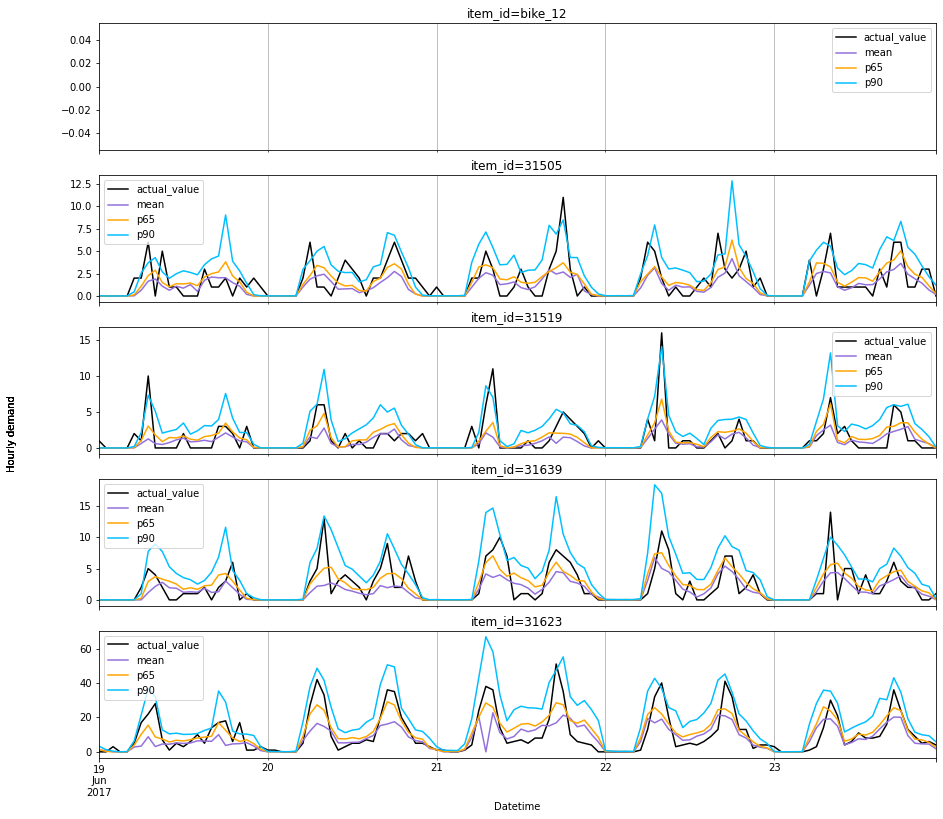

In [33]:
# Visualize items
fig, axs = plt.subplots(len(random_items), 1, figsize=(15, 15), sharex=True)

for i in range(len(random_items)):
    
    item = random_items[i]
    zoomed = df_plot.loc[(df_plot[item_id]==item), :].copy()

    zoomed[['actual_value']].plot(ax=axs[i], color='k')
    colors = ['mediumpurple', 'orange', 'deepskyblue']
    
    for j in range(len(quantile_cols)):
        quantile = quantile_cols[j]
        zoomed[[quantile]].plot(ax=axs[i], color=colors[j])
            
    axs[i].set_title(f"item_id={item}")  
    # set common Y label 
    fig.text(0.04, 0.5, 'Hourly demand', va='center', rotation='vertical')
    
    # format the x ticks
    axs[i].set_xlabel("Datetime")   
        
    # format the grid
    axs[i].grid(False)
    axs[i].grid(which='minor', axis='x')

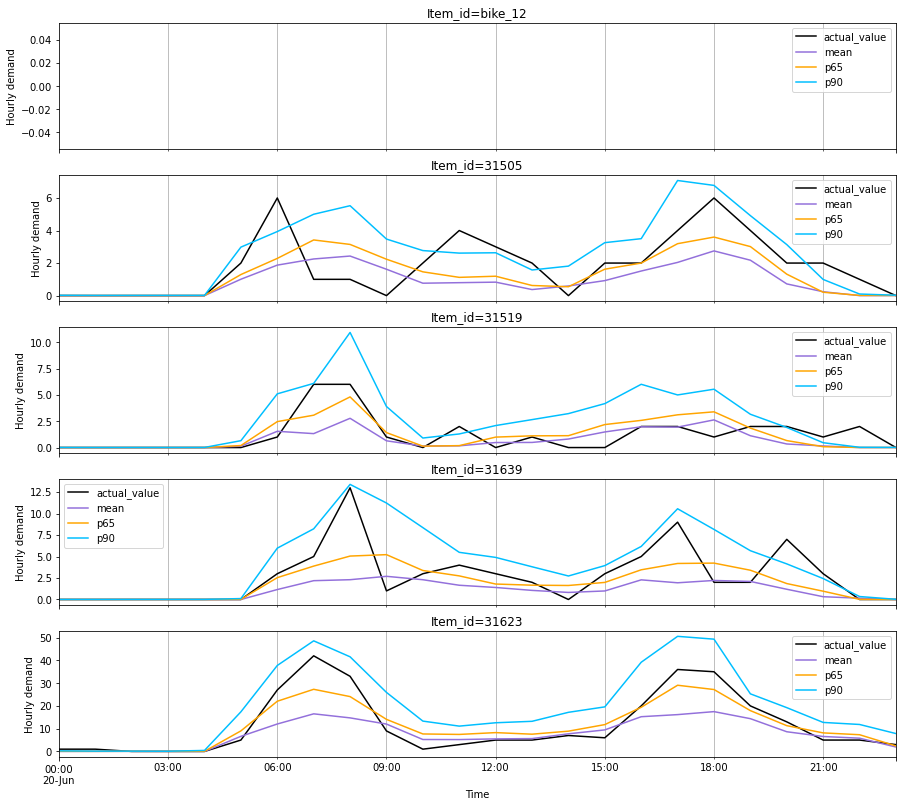

In [34]:
# Visualize items - zoom in to see hours
fig, axs = plt.subplots(len(random_items), 1, figsize=(15, 15), sharex=True)


for i in range(len(random_items)):
    
    item = random_items[i]
    zoomed = df_plot.loc[(df_plot[item_id]==item), :].copy()
    zoomed = zoomed['2017-06-20':'2017-06-20']

    zoomed[['actual_value']].plot(ax=axs[i], color='k')    
    colors = ['mediumpurple', 'orange', 'deepskyblue']
    
    for j in range(len(quantile_cols)):
        quantile = quantile_cols[j]
        zoomed[[quantile]].plot(ax=axs[i], color=colors[j])
            
    axs[i].set_title(f"Item_id={item}")
    axs[i].set_xlabel("Time")    #date
    axs[i].set_ylabel("Hourly demand")   
    axs[i].grid(which='minor', axis='x')


Above, peak hours for bicycle rental appear to be between 5-9am and 3-9pm.  For a real customer study, we really should select more data to verify the peak hours...
<br>

## Cleanup

In [ ]:
delete_backtest_export_job_response = \
    forecast.delete_predictor_backtest_export_job(PredictorBacktestExportJobArn = backtest_export_job_arn)
delete_backtest_export_job_response